# Explore the MCMC sampler for a bimodal distribution
## Issue #25
**_This notebook exists to explore blackjax's functionality / learn about MCMC. Not directly part of this package / project._**

**Author:** Gordon J. Koehn
**Working Period:** 21.04. - XX.04.2023
**Status:** Work in progress

### Aim:
 To explore the MCMC sampler for a bimodal distribution, leading to a better understanding of the sampler and the results.
### Objectives:
1) Create a bimodal distribution  $\log p(x) = -(x-1)^2 + \mathrm{const.}$.
2) Create a MCMC sampler for this distribution using the 'blackJAX'
3) Explore the sampler and the results
   3.1) How do they compare to the true distribution?
   3.2) What happens if you wrap the MCMC sampler in the SMC (again, in BlackJAX)?

## Search for Web Resources
This tutorial on [Use Tempered SMC to Improve Exploration of MCMC Methods.](https://blackjax-devs.github.io/sampling-book/algorithms/TemperedSMC.html) from the _Sampling Book Project_
seems to be exactly what I am looking for. This workbook will follow this tutorial.

## Imports

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.scipy.stats import multivariate_normal

jax.config.update("jax_platform_name", "cpu")

import blackjax
import blackjax.smc.resampling as resampling

## Sampling From a Bimodal Potential
### Experimental Setup

In [2]:
def V(x):
    # note times 5 which is equaled out by the lambdas  ??
    return 5 * jnp.square(jnp.sum(x**2) - 1)


def prior_log_prob(x):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d))


linspace = jnp.linspace(-2, 2, 5000).reshape(-1, 1)
lambdas = jnp.linspace(0.0, 1.0, 5)
# create default normal distribution
prior_logvals = jnp.vectorize(prior_log_prob, signature="(d)->()")(linspace)
# apply potential function
potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)

# vectorized operation of (prior - lambda * potential vals)
log_res = prior_logvals.reshape(1, -1) - jnp.expand_dims(
    lambdas, 1
) * potential_vals.reshape(1, -1)

density = jnp.exp(log_res)
normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (
    linspace[1] - linspace[0]
)
density /= normalizing_factor

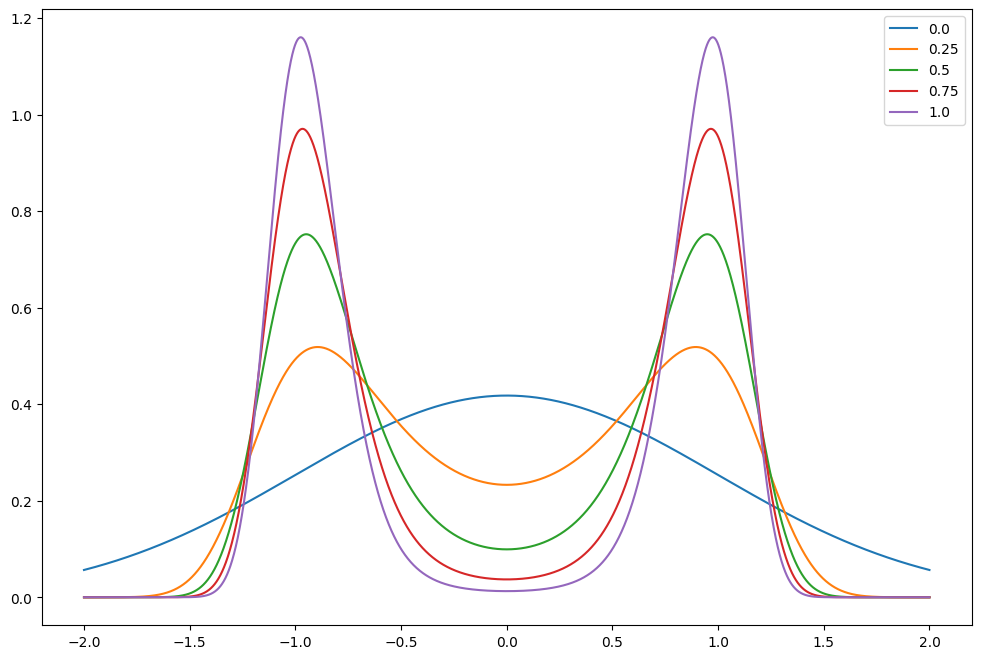

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(linspace.squeeze(), density.T)
ax.legend(list(lambdas))

In [6]:
prior_logvals

Array([-2.9189386, -2.9173386, -2.9157393, ..., -2.9157393, -2.9173386,
       -2.9189386], dtype=float32)

In [32]:
def inference_loop(rng_key, mcmc_kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, k):
        state, _ = mcmc_kernel(k, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


def full_logdensity(x):
    return -V(x) + prior_log_prob(x)


inv_mass_matrix = jnp.eye(1)
n_samples = 10_000

### Sample with HMC

In [33]:
%%time

key = jax.random.PRNGKey(42)

hmc_parameters = dict(
    step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=50
)

hmc = blackjax.hmc(full_logdensity, **hmc_parameters)
hmc_state = hmc.init(jnp.ones((1,)))
hmc_samples = inference_loop(key, hmc.step, hmc_state, n_samples)


CPU times: user 574 ms, sys: 17.4 ms, total: 591 ms
Wall time: 586 ms


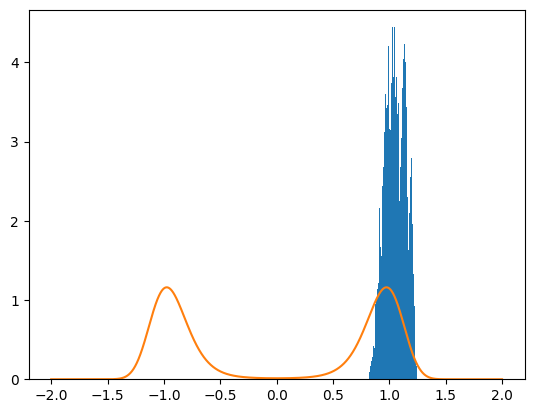

In [34]:
samples = np.array(hmc_samples.position[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

### Sample with Nuts

What is a nuts kernel:
The nuts module is a flexible implementation of several Markov chain Monte Carlo (MCMC) algorithms, including MH and NUTS, that allows you to define custom log probability functions and proposal distributions.

In [35]:
%%time

nuts_parameters = dict(step_size=1e-4, inverse_mass_matrix=inv_mass_matrix)

nuts = blackjax.nuts(full_logdensity, **nuts_parameters)
nuts_state = nuts.init(jnp.ones((1,)))
nuts_samples = inference_loop(key, nuts.step, nuts_state, n_samples)

CPU times: user 5.87 s, sys: 88.8 ms, total: 5.96 s
Wall time: 6.11 s


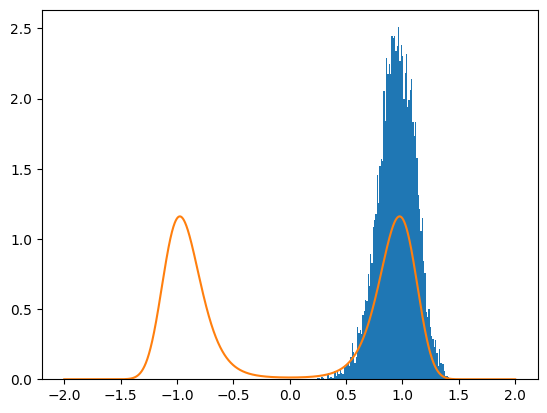

In [36]:
samples = np.array(nuts_samples.position[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

#### Interlude: Implement simple Metropolis Hastings

Alright this does not use blackjax and is deadslow in comparison.

In [50]:
def log_prob(x):
    return -((x**2 - 1)**2)

def proposal(x, key):
    # Gaussian random walk proposal
    return x + jax.random.normal(key) * 0.3

def acceptance_probability(x_proposed, x_current):
    # Compute the acceptance probability using the log ratio of probabilities
    return jnp.minimum(0., log_prob(x_proposed) - log_prob(x_current))

def mh_sampler(key, num_samples):
    init_state = jnp.zeros(1)
    states = [init_state]
    current_log_prob = log_prob(init_state)
    for i in range(num_samples):
        # Generate a proposal state and compute the acceptance probability
        key, subkey = jax.random.split(key)
        proposed_state = proposal(states[-1], subkey)
        proposed_log_prob = log_prob(proposed_state)
        alpha = acceptance_probability(proposed_log_prob, current_log_prob)

        # Accept or reject the proposal based on the acceptance probability
        key, subkey = jax.random.split(key)
        if jnp.log(jax.random.uniform(subkey)) < alpha:
            states.append(proposed_state)
            current_log_prob = proposed_log_prob
        else:
            states.append(states[-1])

    samples = jnp.array(states[1:])
    return samples

In [51]:
%%time
# Generate 100000 MH samples
key = jax.random.PRNGKey(0)
samples = mh_sampler(key, num_samples=100)

CPU times: user 258 ms, sys: 5.88 ms, total: 264 ms
Wall time: 264 ms


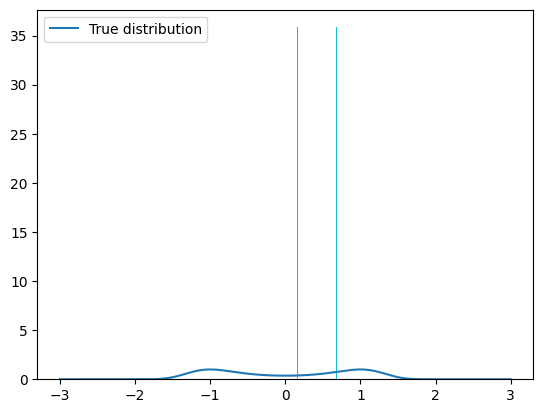

CPU times: user 14.5 s, sys: 362 ms, total: 14.8 s
Wall time: 14.7 s


In [52]:
%%time
import matplotlib.pyplot as plt
# Plot the histogram of the samples and the true distribution
x = jnp.linspace(-3, 3, 1000)
#plt.hist(samples, density=True, bins=50, alpha=0)
plt.hist(samples, bins=100, density=True)
plt.plot(x, jnp.exp(log_prob(x)), label='True distribution')
plt.legend()
plt.show()

Trying to do the same thing with blackjax. - Mhh, acutaly I cannot find a simple equivalent in the blackjax documentation - I must be missing something about the 'nuts' sampler.

**TO BE CONTINUED**